In [1]:
!pip install d2l
!pip install matplotlib==3.0.0
import torch
from d2l import torch as d2l
from torch import nn
import numpy as np
import pandas as pd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 82 kB 658 kB/s 
     |████████████████████████████████| 9.9 MB 34.3 MB/s 
     |████████████████████████████████| 61 kB 10.7 MB/s 
     |████████████████████████████████| 11.2 MB 53.0 MB/s 
     |████████████████████████████████| 15.7 MB 52.9 MB/s 
     |████████████████████████████████| 944 kB 49.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 14.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 requires matplotlib!=3.0.0,>=2.0.0, but you have matplotlib 3.0.0 which is incompatible.
plotnine 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
mizani 0.6.0 requires matplotlib>=3.1.1, but you have matplotlib 3.0.0 which is incompatible.
d2l 0.17.5 requires matplotlib==3.5.1, but you have matplotlib 3.0.0 which is incompatible.
alb

In [79]:
train = pd.read_csv('/content/sample_data/used_car_train_20200313.csv', sep=' ')

test_data = pd.read_csv(r'/content/sample_data/used_car_testB_20200421.csv', sep=' ')


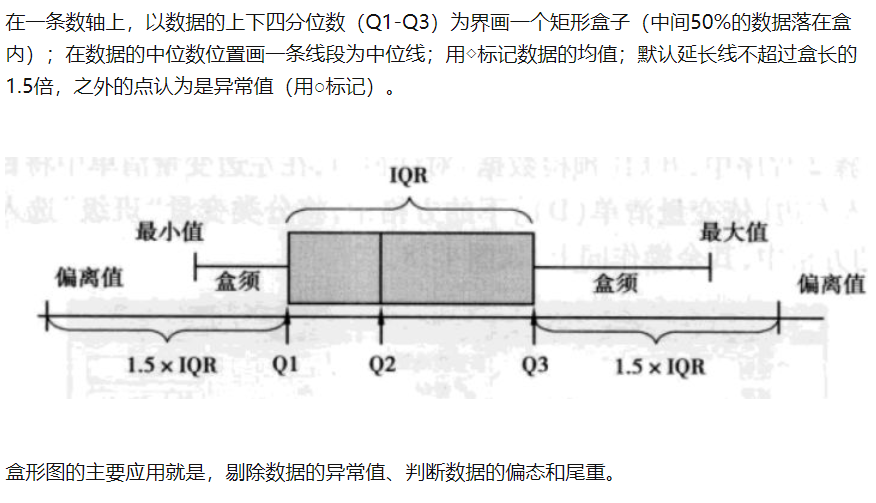

In [80]:
# 进行数据处理
# 异常值删除，注意test中的数据不能删除，此方法考虑后使用,这里不选择删除元素，而是进行数据分桶

import matplotlib.pyplot as plt
import seaborn as sns

def outliers_proc(data, col_name, scale=3):
    # 用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    # :param data: 接收 pandas 数据格式
    # :param col_name: pandas 列名
    # :param scale: 尺度
    # :return:

    def box_plot_outliers(data_ser, box_scale):
        # 利用箱线图去除异常值
        # :param data_ser: 接收 pandas.Series 数据格式
        # :param box_scale: 箱线图尺度，
        # :return:

        # data.quantile(0.75)求的是数据项的较大四分位数，即数据项从小到大排列第75%的数字
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        # val_low对应上图中的最小偏移值，如果不清楚可以通过画图来理解
        val_low = data_ser.quantile(0.25) - iqr
        # val_up对应上图中的最大偏移值
        val_up = data_ser.quantile(0.75) + iqr
        # 返回True或者False
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)

        # 返回两个列表
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    # 索引列向量的所有数据，若其数据超出偏移值，即(rule[0] or rule[1] == True)，则将其索引放入index中
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    # 输出删除数据的长度
    print("Delete number is: {}".format(len(index)))
    # 直接删除需要drop的行元素
    data_n = data_n.drop(index)
    # 重置索引
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))

    # 输出对所有小于下限而被删除的数据的描述
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    # 输出所有大于上限而被删除的数据的描述
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    # 画图对比数据处理前后的数据
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


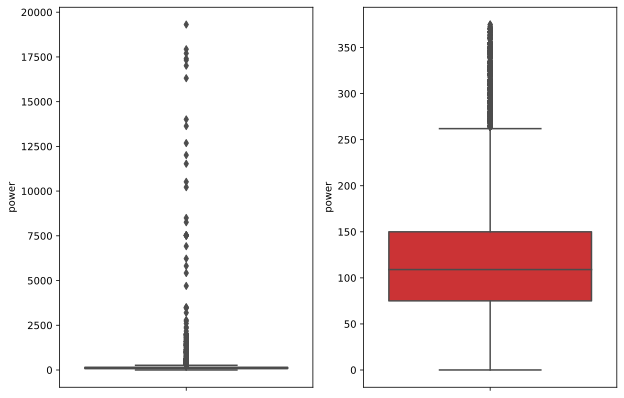

In [81]:
# 此处选择删除异常数据
train = outliers_proc(train, 'power', scale=3)

In [82]:
# 整合数据集和测试集
train_data = train.drop(['price'], axis=1, inplace=False)
all_features = pd.concat((train_data.iloc[:, 1:], test_data.iloc[:, 1:]))

# print(all_features['regionCode'].isnull().sum())



# 数据分析
# all_features.describe()
# all_features.info()
# all_features.isnull().sum()
# all_features['notRepairedDamage'].value_counts()
# all_features['seller'].value_counts()
# all_features['offerType'].value_counts()

# 数据处理
# 将数据中的'-'替换成nan
all_features['notRepairedDamage'].replace('-', np.nan, inplace=True)


# 以下两个数据项对预测无影响，故可直接删除
del all_features['seller'] # 只有一项数据为1，其他均为0
del all_features['offerType'] # 所有数据项均为0

print(all_features.shape)

(199037, 27)


In [83]:
# 在数据中添加一项使用时间：all_features['creatDate'] - all_features['regDate']，反应汽车使用时间，一般来说价格与使用时间成反比
# 不过要注意，数据里有时间出错的格式，所以我们需要 errors='coerce'，将不能转换的数据变为nan
all_features['used_time'] = (pd.to_datetime(all_features['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(all_features['regDate'], format='%Y%m%d', errors='coerce')).dt.days
# 查看新增的used_time项发现大量样本时间有问题，但是由于占总数据的7.5%，所以不推荐删除数据
all_features['used_time'].isnull().sum()

15054

In [84]:
# 通过邮编添加一个city项
all_features['city'] = all_features['regionCode'].apply(lambda x : str(x)[:-3])
all_features['city'] = pd.to_numeric(all_features['city'], errors='coerce') # error='coerce'表示不能转的变为nan

In [85]:
# 计算某品牌的销售统计量，最高售价等参数，并将这些参数添加到测试数据中
# 这里要以 train 的数据计算统计量，data.groupby()函数以其中参数来整合数据
train_gb = train.groupby("brand")
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
all_features = all_features.merge(brand_fe, how='left', on='brand')

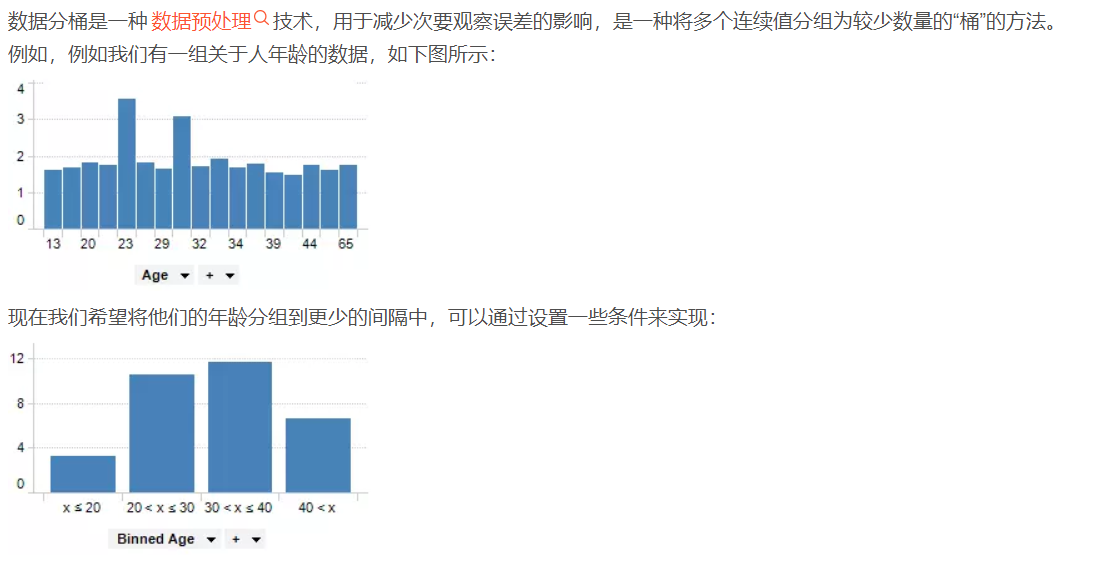

In [86]:
# 数据分桶 以 power 为例
# 这时候我们的缺失值也进桶了，
# 为什么要做数据分桶呢，原因有很多，= =
# 1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
# 2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
# 3. LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
# 4. 离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；
# 5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化

# 当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性

# 添加一个'power_bin'的索引项
bin = [i*10 for i in range(31)]
# pd.cut()函数是左闭右开区间
all_features['power_bin'] = pd.cut(all_features['power'], bin, labels=False)
all_features[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [87]:
# 删除不需要的数据
all_features = all_features.drop(['creatDate', 'regDate', 'regionCode'], axis = 1)

In [88]:
all_features.columns
print(all_features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199037 entries, 0 to 199036
Data columns (total 34 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   name                 199037 non-null  int64  
 1   model                199036 non-null  float64
 2   brand                199037 non-null  int64  
 3   bodyType             193039 non-null  float64
 4   fuelType             187481 non-null  float64
 5   gearbox              191115 non-null  float64
 6   power                199037 non-null  int64  
 7   kilometer            199037 non-null  float64
 8   notRepairedDamage    166748 non-null  object 
 9   v_0                  199037 non-null  float64
 10  v_1                  199037 non-null  float64
 11  v_2                  199037 non-null  float64
 12  v_3                  199037 non-null  float64
 13  v_4                  199037 non-null  float64
 14  v_5                  199037 non-null  float64
 15  v_6              

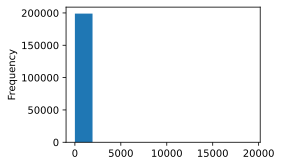

In [89]:
all_features['power'].plot.hist()

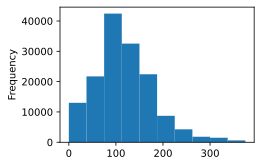

In [90]:
# 我们刚刚已经对 train 进行异常值处理了，但是现在还有这么奇怪的分布是因为 test 中的 power 异常值，
# 所以我们其实刚刚 train 中的 power 异常值不删为好，可以用长尾分布截断来代替
# 我们可以把大于某个值之后的数据都赋为这个值，例如大于400的值都赋值400。另外，服从长尾分布的数据一般都建议先取log再归一化。
train_data['power'].plot.hist()

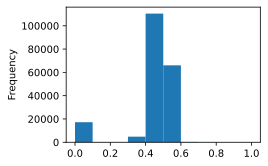

In [91]:
# 取log再进行归一化
# 归一化的目的就是使得预处理的数据被限定在一定的范围内（比如[0,1]或者[-1,1]），从而消除奇异样本数据导致的不良影响。
# 奇异样本数据是指相对于其他输入样本特别大或特别小的样本矢量（即特征向量）
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
all_features['power'] = np.log(all_features['power'] + 1)
all_features['power'] = ((all_features['power'] - np.min(all_features['power'])) / (np.max(all_features['power']) - np.min(all_features['power'])))
all_features['power'].plot.hist()

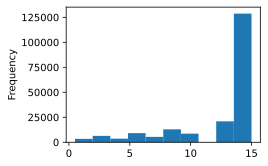

In [92]:
# km的比较正常，应该做过分桶，故可直接做归一化
all_features['kilometer'].plot.hist()



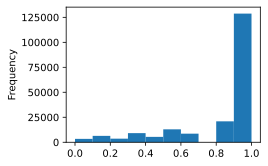

In [93]:
# 归一化
all_features['kilometer'] = ((all_features['kilometer'] - np.min(all_features['kilometer'])) / 
                        (np.max(all_features['kilometer']) - np.min(all_features['kilometer'])))
all_features['kilometer'].plot.hist()

In [94]:
# 对刚刚构造的数据项进行归一化
def max_min(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

all_features['brand_amount'] = ((all_features['brand_amount'] - np.min(all_features['brand_amount'])) / 
                        (np.max(all_features['brand_amount']) - np.min(all_features['brand_amount'])))
all_features['brand_price_average'] = ((all_features['brand_price_average'] - np.min(all_features['brand_price_average'])) / 
                               (np.max(all_features['brand_price_average']) - np.min(all_features['brand_price_average'])))
all_features['brand_price_max'] = ((all_features['brand_price_max'] - np.min(all_features['brand_price_max'])) / 
                           (np.max(all_features['brand_price_max']) - np.min(all_features['brand_price_max'])))
all_features['brand_price_median'] = ((all_features['brand_price_median'] - np.min(all_features['brand_price_median'])) /
                              (np.max(all_features['brand_price_median']) - np.min(all_features['brand_price_median'])))
all_features['brand_price_min'] = ((all_features['brand_price_min'] - np.min(all_features['brand_price_min'])) / 
                           (np.max(all_features['brand_price_min']) - np.min(all_features['brand_price_min'])))
all_features['brand_price_std'] = ((all_features['brand_price_std'] - np.min(all_features['brand_price_std'])) / 
                           (np.max(all_features['brand_price_std']) - np.min(all_features['brand_price_std'])))
all_features['brand_price_sum'] = ((all_features['brand_price_sum'] - np.min(all_features['brand_price_sum'])) / 
                           (np.max(all_features['brand_price_sum']) - np.min(all_features['brand_price_sum'])))

In [95]:
# 对类别特征进行 OneEncoder (独热编码)
all_features = pd.get_dummies(all_features, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage', 'power_bin'])

In [96]:
print(all_features.shape)
all_features.columns
print(all_features.info())

(199037, 364)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 199037 entries, 0 to 199036
Columns: 364 entries, name to power_bin_29.0
dtypes: float64(26), int64(1), uint8(337)
memory usage: 106.5 MB
None


In [97]:
all_features_mean = all_features.mean(axis=0)
all_features = all_features.fillna(all_features_mean)
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train.price.values.reshape(-1, 1), dtype=torch.float32)


In [98]:
# 定义损失函数和模型
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
  net = nn.Sequential(nn.Linear(in_features, 64), nn.ReLU(), nn.Linear(64, 1))
  return net


In [99]:
def rmse(net, features, labels):
  rmse = (labels - net(features)).abs() 
  return (rmse.sum() / features.shape[0]).item()

In [100]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
  train_ls, test_ls = [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  # 使用Adam优化算法
  optimizer = torch.optim.Adam(net.parameters(),
                  lr = learning_rate,
                  weight_decay = weight_decay)
  for epoch in range(num_epochs):
    for X, y in train_iter:
      optimizer.zero_grad()
      l = loss(net(X), y)
      l.backward() # 梯度下降
      optimizer.step() # 优化参数
    train_ls.append(rmse(net, train_features, train_labels))
    if test_labels is not None:
      # 这里后续的参数实际上还是train_features，因为后续的k折交叉验证使用的是train_features的1/k折数据
      test_ls.append(rmse(net, test_features, test_labels)) 
  return train_ls, test_ls
  
  

In [101]:
# 将数据分为k个部分，其中一部分为验证集
def get_k_fold_data(k, i, X, y):
  assert k>1
  fold_size = X.shape[0] // k # 向下取整
  X_train, y_train = None, None
  for j in range(k):
    idx = slice(j*fold_size, (j+1)*fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = torch.cat([X_train, X_part], 0)
      y_train = torch.cat([y_train, y_part], 0)
  return X_train, y_train, X_valid, y_valid


In [102]:
# k折交叉验证
# 这里后续的参数实际上还是train_features，因为后续的k折交叉验证使用的是train_features的1/k折数据
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
  train_l_sum, valid_l_sum = 0, 0
  for i in range(k):
    data = get_k_fold_data(k, i, X_train, y_train)
    net = get_net()
    train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                   weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
    print(f'折{i + 1}，训练 rmse{float(train_ls[-1]):f}, '
              f'验证 rmse{float(valid_ls[-1]):f}')
  
  return train_l_sum / k, valid_l_sum / k

折1，训练 rmse1280.531128, 验证 rmse1270.888672
折2，训练 rmse969.374084, 验证 rmse973.257263
折3，训练 rmse945.320435, 验证 rmse967.680725
折4，训练 rmse1064.982178, 验证 rmse1048.650513
折5，训练 rmse942.761230, 验证 rmse957.091919
5-折验证: 平均训练 rmse: 1040.593811, 平均验证 rmse: 1043.513818


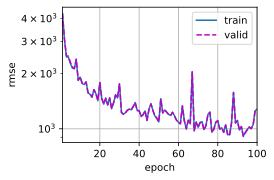

In [103]:
# 定义超参数进行训练
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.001, 0, 64
# 这里后续的参数实际上还是train_features，因为后续的k折交叉验证使用的是train_features的1/k折数据
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, 
               lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练 rmse: {float(train_l):f}, '
      f'平均验证 rmse: {float(valid_l):f}')